In [3]:
# ------------------------------------------------------------------
# 0.  Imports & folder paths  --------------------------------------
# ------------------------------------------------------------------
from pathlib import Path
import geopandas as gpd
import pandas as pd

BASE = Path.home() / "Desktop" / "detroit"              # ← change if needed

HOLC_PATH   = BASE / "Mapping_Inequality" / "mappinginequality.json"
TRACT_SHAPE = BASE / "2020_Census_TIGER" / "tl_2020_26_tract.shp"
OA_PATH     = BASE / "Opportunity_Atlas_Data_Tables" / "tract_outcomes_simple.csv"
FC_PATH     = BASE / "Detroit_Tax_Foreclosures_2002_2019" / "foreclosures_2002-2019__2020addresses.csv"

# ------------------------------------------------------------------
# 1.  Read spatial layers (use pyogrio, no Fiona needed) -----------
# ------------------------------------------------------------------
holc = gpd.read_file(HOLC_PATH, engine="pyogrio").to_crs(4326)

tracts = (gpd.read_file(TRACT_SHAPE, engine="pyogrio")[["GEOID", "geometry"]]
            .to_crs(4326))
tracts["GEOID"] = tracts["GEOID"].astype(str).str.zfill(11)   # ensure string key

# ------------------------------------------------------------------
# 2.  Opportunity-Atlas: build 11-digit tract_id -------------------
# ------------------------------------------------------------------
oa = pd.read_csv(OA_PATH, dtype=str)                    # keep strings

oa["tract_id"] = (
    oa["state"].str.zfill(2) +
    oa["county"].str.zfill(3) +
    oa["tract"].str.zfill(6)
)

# ---- pick only the OA metrics you plan to map (edit as you like) --
oa_subset = oa[["tract_id",
                "kfr_black_pooled_p25",          # Black kids’ adult income (p25)
                "jail_black_pooled_p25"]]        # Black incarceration rate

# ------------------------------------------------------------------
# 3.  Merge TIGER tracts  ↔  Opportunity-Atlas ---------------------
# ------------------------------------------------------------------
tracts_oa = tracts.merge(oa_subset, left_on="GEOID", right_on="tract_id", how="left")

# ------------------------------------------------------------------
# 4.  Foreclosure points → tract counts & density ------------------
# ------------------------------------------------------------------
fc = pd.read_csv(FC_PATH)
fc_gdf = gpd.GeoDataFrame(fc,
                          geometry=gpd.points_from_xy(fc.longitude, fc.latitude),
                          crs=4326)

fc_by_tract = (gpd.sjoin(fc_gdf, tracts, how="inner", predicate="within")
                 .groupby("GEOID").size()
                 .rename("fc_count")                    # number of foreclosures
                 .to_frame())

tracts_full = tracts_oa.join(fc_by_tract, on="GEOID")
tracts_full["fc_density"] = tracts_full["fc_count"] / tracts_full.area

# ------------------------------------------------------------------
# 5.  Quick sanity-check  ------------------------------------------
# ------------------------------------------------------------------
print(tracts_full[["GEOID",
                   "kfr_black_pooled_p25",
                   "jail_black_pooled_p25",
                   "fc_count",
                   "fc_density"]].head())

print(f"\nTotal Detroit tracts loaded: {len(tracts_full)}")


AttributeError: 'DataFrame' object has no attribute 'longitude'

In [5]:
import pandas as pd

pd.read_csv(FC_PATH, nrows=0).columns.tolist()
# → something like ['tract', 'state_name', 'income_p25', ...]


['prop_addr',
 'prop_parcelnum',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019']

In [9]:
# ------------------- 0. Imports & paths ---------------------------
from pathlib import Path
import geopandas as gpd
import pandas as pd
import folium, branca
import contextily as cx
import matplotlib.pyplot as plt

BASE = Path.home() / "Desktop" / "detroit"

HOLC_PATH   = BASE/"Mapping_Inequality"/"mappinginequality.json"
TRACT_PATH  = BASE/"2020_Census_TIGER"/"tl_2020_26_tract.shp"
OA_PATH     = BASE/"Opportunity_Atlas_Data_Tables"/"tract_outcomes_simple.csv"

OUTDIR = BASE/"outputs"
OUTDIR.mkdir(parents=True, exist_ok=True)

# ------------------- 1. Load spatial data -------------------------
holc = gpd.read_file(HOLC_PATH,  engine="pyogrio").to_crs(4326)

tracts = (gpd.read_file(TRACT_PATH, engine="pyogrio")
            .to_crs(4326)[["GEOID", "geometry"]])
tracts["GEOID"] = tracts["GEOID"].astype(str).str.zfill(11)

# ------------------- 2. Opportunity-Atlas merge -------------------
oa = pd.read_csv(OA_PATH, dtype=str)
oa["tract_id"] = (
    oa["state"].str.zfill(2) +
    oa["county"].str.zfill(3) +
    oa["tract"].str.zfill(6)
)

oa_subset = oa[["tract_id",
                "kfr_black_pooled_p25",      # adult income P25
                "jail_black_pooled_p25"]]    # jail rate (per 100 000)

tracts_oa = tracts.merge(oa_subset, left_on="GEOID",
                         right_on="tract_id", how="left")

# ------------------- 3. Interactive Folium map --------------------
def make_map(value_col, legend, html_name):
    m = folium.Map(location=[42.36, -83.05], zoom_start=11,
                   tiles="cartodbpositron")
    folium.Choropleth(
        geo_data=tracts_oa,
        data=tracts_oa,
        columns=["GEOID", value_col],
        key_on="feature.properties.GEOID",
        fill_color="YlOrRd",
        nan_fill_color="lightgray",
        bins=8,
        legend_name=legend,
        line_opacity=0.2,
        fill_opacity=0.8,
    ).add_to(m)

    # HOLC overlay (light)
    holc_style = lambda feat: {
        "fillColor": {"A":"#00ff00","B":"#7fff00","C":"#ffa500","D":"#ff0000"}[
            feat["properties"]["holc_grade"]],
        "color": "#000000", "weight": 0.4, "fillOpacity": 0.15
    }
    folium.GeoJson(holc, style_function=holc_style,
                   name="1939 HOLC").add_to(m)

    folium.LayerControl().add_to(m)
    m.save(OUTDIR/html_name)
    print(f"✔ saved {html_name}")

make_map("kfr_black_pooled_p25",
         "Black children’s adult income (p25, $)",
         "vis1_income_holc.html")

make_map("jail_black_pooled_p25",
         "Black incarceration rate per 100k",
         "vis2_jail_holc.html")

# ------------------- 4. Small-multiple PNGs -----------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
cols = ["kfr_black_pooled_p25",
        "jail_black_pooled_p25",
        None]                                   # third = plain HOLC

titles = ["Income (Black, $p25)",
          "Jail rate (Black, per 100k)",
          "1939 HOLC grade"]

for ax, col, title in zip(axes, cols, titles):
    if col:                                     # OA variable map
        tracts_oa.plot(col, ax=ax, scheme="quantiles",
                       cmap="YlGnBu", linewidth=0)
    else:                                       # plain HOLC
        holc.plot(column="holc_grade", ax=ax,
                  cmap={"A":"#00ff00","B":"#7fff00",
                        "C":"#ffa500","D":"#ff0000"},
                  legend=False, linewidth=0)
    cx.add_basemap(ax, crs=tracts_oa.crs, source=cx.providers.Stamen.TonerLite)
    ax.set_axis_off(); ax.set_title(title)

plt.tight_layout()



TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [10]:
import pandas as pd
import geopandas as gpd
from shapely import wkt          # needed only if geometry is stored in WKT

# 1. Load the MDOT table
mdot = pd.read_csv("/Users/josephjoeypark/Downloads/MDOT_Real_Estate_Polygons.csv")

# 2. Keep just the freeway we want
i375 = mdot[mdot["ROUTE_ID"] == 375]         # or == "375" if it’s a string

# 3. Turn it into a GeoDataFrame
#      Many MDOT extracts ship a WKT column called 'WKT' or 'SHAPE'; adjust if yours differs
i375["geometry"] = i375["WKT"].apply(wkt.loads)
i375_gdf = gpd.GeoDataFrame(i375, geometry="geometry", crs="EPSG:4326")

# 4. Optional – dissolve the parcels into one shape and save to GeoJSON
footprint = i375_gdf.dissolve()              # single multipart polygon
footprint.to_file("i375_row.geojson", driver="GeoJSON")


KeyError: 'ROUTE_ID'

In [12]:
mdot.keys()

Index(['OBJECTID', 'ParcelSequenceNumber', 'TractId', 'SaleSequenceNumber',
       'CountySheet', 'PolygonType', 'ShapeSTArea', 'ShapeSTLength'],
      dtype='object')

In [13]:
import geopandas as gpd
import pandas as pd
import folium
from shapely.geometry import LineString

# ───────────────────────────────────────────────────────────────
# 1.  LOAD YOUR THREE SOURCE LAYERS
# ───────────────────────────────────────────────────────────────
TRACTS_SHP = "tl_2020_26_tract.shp"          # already in /mnt/data
OA_CSV     = "tract_outcomes_simple.csv"
HOLC_JSON  = "mappinginequality.json"

# Detroit 2020 census tracts  (Wayne County: GEOID starts with 26163)
tracts = gpd.read_file(TRACTS_SHP).to_crs("EPSG:4326")
detroit = tracts.query("GEOID.str.startswith('26163')", engine="python")

# Opportunity-Atlas metric  → build 11-digit GEOID, merge
oa = pd.read_csv(OA_CSV, low_memory=False)
oa["GEOID"] = (oa.state.astype(str).str.zfill(2) +
               oa.county.astype(str).str.zfill(3) +
               oa.tract.astype(str).str.zfill(6))
oa_metric = oa[["GEOID", "kfr_black_pooled_p25"]].rename(
    columns={"kfr_black_pooled_p25": "oa_value"}
)
detroit = detroit.merge(oa_metric, on="GEOID", how="left")

# 1939 HOLC polygons
holc = gpd.read_file(HOLC_JSON).to_crs("EPSG:4326")
holc_det = holc[(holc["city"] == "Detroit") & holc["residential"]]

# ───────────────────────────────────────────────────────────────
# 2.  BUILD AN APPROXIMATE I-375 FOOTPRINT (100 m BUFFER)
# ───────────────────────────────────────────────────────────────
# Two termini: Jefferson Ave & I-75 interchange
centerline = LineString([(-83.03925, 42.33066), (-83.03736, 42.34994)])
i375_buf   = (
    gpd.GeoSeries([centerline], crs="EPSG:4326")
    .to_crs(26917).buffer(100)                 # 100 m ≈ ROW half-width
    .to_crs("EPSG:4326")
)

# ───────────────────────────────────────────────────────────────
# 3.  FOLIUM MAP (NO FILE SAVED)
# ───────────────────────────────────────────────────────────────
m = folium.Map([42.339, -83.038], zoom_start=13, tiles="cartodbpositron")

# Choropleth  –  Opportunity Atlas
folium.Choropleth(
    geo_data=detroit,
    data=detroit,
    columns=["GEOID", "oa_value"],
    key_on="feature.properties.GEOID",
    fill_color="YlOrRd",
    nan_fill_color="lightgray",
    legend_name="Adult income of Black children\n(p25 cohort, 2015 $)"
).add_to(m)

# HOLC overlay
holc_colors = {"A": "#1a9641", "B": "#2c7bb6", "C": "#ffbf00", "D": "#d7191c"}
folium.GeoJson(
    holc_det,
    name="1939 HOLC grade",
    style_function=lambda f: {
        "fillOpacity": 0,
        "color": holc_colors.get(f["properties"]["grade"], "#666"),
        "weight": 1.3,
    },
    tooltip=folium.GeoJsonTooltip(fields=["grade"], aliases=["HOLC grade:"]),
).add_to(m)

# I-375 buffered corridor
folium.GeoJson(
    gpd.GeoDataFrame(geometry=i375_buf),
    name="I-375 corridor (approx.)",
    style_function=lambda _: {
        "color": "black", "weight": 1,
        "fillColor": "gray", "fillOpacity": 0.35,
    },
    tooltip="I-375 urban-renewal footprint (±100 m buffer)",
).add_to(m)

folium.LayerControl().add_to(m)

# Display the map inline (Jupyter / VS Code / Streamlit will render automatically)
m


In [14]:
import json, folium, pandas as pd
from pathlib import Path

BASE   = Path.home() / "Desktop" / "detroit"
GEO    = BASE / "detroit_tracts.geojson"
HOLC   = BASE / "holc_detroit_reproj.geojson"
OA_CSV = BASE / "Opportunity_Atlas_Data_Tables" / "tract_outcomes_simple.csv"
OUT    = BASE / "outputs"
OUT.mkdir(exist_ok=True)

# 2-A  load OA table and carve Detroit tracts
oa = pd.read_csv(OA_CSV, dtype=str)
oa["TRACTID"] = (oa["state"].str.zfill(2) +
                 oa["county"].str.zfill(3) +
                 oa["tract"].str.zfill(6))
keep_cols = ["TRACTID", "kfr_black_pooled_p25", "jail_black_pooled_p25"]
oa = oa[keep_cols].apply(pd.to_numeric, errors="ignore")

# 2-B  helper to build Folium map
def build(col, legend, outfile):
    m = folium.Map(location=[42.36,-83.05], zoom_start=11,
                   tiles="cartodbpositron")
    folium.Choropleth(
        geo_data=str(GEO),
        data=oa,
        columns=["TRACTID", col],
        key_on="feature.properties.GEOID",
        fill_color="YlOrRd",
        nan_fill_color="lightgray",
        bins=8,
        legend_name=legend,
        line_opacity=0.1,
        fill_opacity=0.8
    ).add_to(m)

    # HOLC overlay
    holc_style=lambda f: {"fillColor":
        {"A":"#00ff00", "B":"#7fff00", "C":"#ffa500", "D":"#ff0000"}
        [f["properties"]["holc_grade"]],
        "color":"#000","weight":0.4,"fillOpacity":0.15}
    folium.GeoJson(json.load(open(HOLC)), style_function=holc_style,
                   name="1939 HOLC").add_to(m)
    folium.LayerControl().add_to(m)
    m.save(str(OUT/outfile))
    print("saved", outfile)

build("kfr_black_pooled_p25",
      "Black children’s adult income (p25)",
      "vis1_income.html")

build("jail_black_pooled_p25",
      "Black incarceration rate per 100 000",
      "vis2_jail.html")


/var/folders/ds/gwcklq3s5hz63g6lz2gxzgnr0000gn/T/ipykernel_9366/4023913585.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  oa = oa[keep_cols].apply(pd.to_numeric, errors="ignore")


KeyError: 'holc_grade'

In [4]:
# -------------------------------------------------------------------
#  I-375 ROW + accuracy check + quick Folium map
# -------------------------------------------------------------------
import osmnx as ox
import geopandas as gpd
import folium

# 1) Download Detroit road network and isolate I-375 center-line
G      = ox.graph_from_place("Detroit, Michigan, USA", network_type="drive")
edges  = ox.graph_to_gdfs(G, nodes=False, edges=True)
i375   = edges[edges["name"].str.contains("I 375", na=False)]

# 2) Buffer the center-line in *meters* (35 m each side ≈ 70 m ROW)
row    = (
    i375.to_crs(26917)        # UTM-17N, EPSG:26917 (units = m)
        .buffer(35)           # 35-m half-width
        .to_crs(4326)         # back to WGS84 for web maps
)

 

 
# 5) Quick interactive map
m = folium.Map(location=[42.3377, -83.0385], zoom_start=15,
               tiles="cartodbpositron")

folium.GeoJson(
    row,
    style_function=lambda *_: {"color": "#ff5722", "weight": 1,
                               "fillOpacity": 0.20},
    name="Buffered ROW (70 m)"
).add_to(m)
 

folium.LayerControl(collapsed=False).add_to(m)

# ──> display(m) in Jupyter, or: m.save("detroit_i375_row.html")


In [5]:
display(m) 

In [6]:
import geopandas as gpd
import osmnx as ox
import folium

# ------------------------------------------
# 1. TIGER/Line Primary Roads – Michigan
# ------------------------------------------
url = (
    "https://www2.census.gov/geo/tiger/TIGER2024/PRISRD/"
    "tl_2024_26_prisrd.zip"             # 26 = Michigan
)

roads = gpd.read_file(f"zip://{url}")   # GeoPandas can stream zips

# Keep only the interstate we need
i375 = roads[
    (roads["FULLNAME"].str.contains("I-375", na=False)) &  # name match
    (roads["RTTYP"] == "I")                                # interstate flag
]

# ------------------------------------------
# 2. Buffer exactly 35 m each side (70 m ROW)
# ------------------------------------------
row = (
    i375.to_crs(26917)     # UTM 17 N – metres
        .buffer(35)        # half-width
        .to_crs(4326)      # back to WGS-84 for web maps
)

# ------------------------------------------
# 3. (Optional) Cross-check with OpenStreetMap
#    – not mandatory, but nice for QC
# ------------------------------------------
G      = ox.graph_from_place("Detroit, Michigan, USA", network_type="drive")
edges  = ox.graph_to_gdfs(G, nodes=False, edges=True)
osm    = edges[edges["name"].str.contains("I 375", na=False)].to_crs(4326)

# 4. Quick Hausdorff-ish sanity check (max centre-line gap, metres)
gap = row.unary_union.distance(osm.unary_union) * 111_000
print(f"Max TIGER ↔ OSM offset ≈ {gap:.1f} m")

# ------------------------------------------
# 5. Interactive Folium map
# ------------------------------------------
m = folium.Map(location=[42.3377, -83.0385], zoom_start=15,
               tiles="cartodbpositron")

folium.GeoJson(
    row,
    style_function=lambda *_: {"color": "#e91e63", "weight": 1,
                               "fillOpacity": 0.25},
    name="Buffered ROW (TIGER, 70 m)"
).add_to(m)

folium.GeoJson(
    osm,
    style_function=lambda *_: {"color": "#0d47a1", "weight": 2},
    name="OSM centre-line (QC)"
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

# display(m) in Jupyter, or save:
# m.save("detroit_i375_row_tiger.html")


DataSourceError: '/vsizip/https://www2.census.gov/geo/tiger/TIGER2024/PRISRD/tl_2024_26_prisrd.zip' does not exist in the file system, and is not recognized as a supported dataset name.

In [7]:
# -------------------------------------------------------
# Detroit I-375 land-bridge context map (Wayne County)
# -------------------------------------------------------
import geopandas as gpd
import re
import folium

# 0.  Paths to the two datasets you already uploaded
roads_path = "tl_2024_26163_roads.shp"          # with .shx present!
holc_path  = "mappinginequality.json"

# 1.  Load Wayne-County roads and filter to I-375 mainline
roads = gpd.read_file(roads_path)
i375  = roads[
    roads["FULLNAME"].str.contains(r"I[- ]?375", flags=re.I, na=False) &
    (roads["MTFCC"] == "S1100")       # motorway spine only
]

# 2.  Buffer 35 m → ~70 m right-of-way polygon
row = (
    i375.to_crs(26917)                # metres (UTM-17N)
         .buffer(35)                  # half-width
         .to_crs(4326)                # back to WGS-84
)
row = gpd.GeoDataFrame(geometry=row, crs="EPSG:4326")

# 3.  Load 1939 HOLC polygons for Detroit
holc = gpd.read_file(holc_path)
holc_det = holc[holc["city"] == "Detroit"].to_crs(4326)
grade_colors = {"A":"#4caf50","B":"#2196f3","C":"#ffeb3b","D":"#f44336"}

# 4.  Build interactive Folium map
center = [row.geometry.centroid.y.mean(),
          row.geometry.centroid.x.mean()]
m = folium.Map(location=center, zoom_start=15, tiles="cartodbpositron")

folium.GeoJson(
    holc_det,
    style_function=lambda f: {
        "color": grade_colors[f["properties"]["grade"]],
        "fillColor": grade_colors[f["properties"]["grade"]],
        "weight": 1, "fillOpacity": 0.15},
    name="1939 HOLC zones",
    tooltip=folium.features.GeoJsonTooltip(fields=["label","grade"],
                                           aliases=["Area","Grade"])
).add_to(m)

folium.GeoJson(
    row,
    style_function=lambda *_: {
        "color":"#e91e63","weight":2,"fillOpacity":0.25},
    name="I-375 ROW (~70 m)"
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m.save("i375_holc_map.html")           # upload this HTML to your site
m                                      # shows inline in Jupyter


/var/folders/ds/gwcklq3s5hz63g6lz2gxzgnr0000gn/T/ipykernel_11080/2016478158.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [row.geometry.centroid.y.mean(),
/var/folders/ds/gwcklq3s5hz63g6lz2gxzgnr0000gn/T/ipykernel_11080/2016478158.py:34: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  row.geometry.centroid.x.mean()]


ValueError: Location values cannot contain NaNs.

In [8]:
print(f"I-375 features: {len(i375)}")


I-375 features: 0


In [11]:
import geopandas as gpd
import re
import folium

# 0.  Paths
roads_path = "tl_2024_26163_roads.shp"
holc_path  = "mappinginequality.json"

# 1.  Load roads & filter to I-375
roads = gpd.read_file(roads_path)

i375 = roads[
    roads["FULLNAME"].str.contains(r"I[- ]?375", flags=re.I, na=False) &
    (roads["RTTYP"] == "I")
]

print(f"I-375 features: {len(i375)}")  # should be >0

# 2.  Buffer 35 m for ROW
row = (
    i375.to_crs(26917)
         .buffer(35)
         .to_crs(4326)
)
row = gpd.GeoDataFrame(geometry=row, crs="EPSG:4326")

# 3.  Load HOLC & subset to Detroit
holc = gpd.read_file(holc_path)
holc_det = holc[holc["city"] == "Detroit"].to_crs(4326)
grade_colors = {"A":"#4caf50","B":"#2196f3","C":"#ffeb3b","D":"#f44336"}

# 4.  Compute map center from ROW bounds
minx, miny, maxx, maxy = row.total_bounds
center = [(miny + maxy) / 2, (minx + maxx) / 2]

# 5.  Build Folium map inline
m = folium.Map(location=center, zoom_start=15, tiles="cartodbpositron")

folium.GeoJson(
    holc_det,
    style_function=lambda f: {
        "color": grade_colors[f["properties"]["grade"]],
        "fillColor": grade_colors[f["properties"]["grade"]],
        "weight": 1, "fillOpacity": 0.15
    },
    name="1939 HOLC zones",
    tooltip=folium.features.GeoJsonTooltip(fields=["label","grade"],
                                           aliases=["Area","Grade"])
).add_to(m)

folium.GeoJson(
    row,
    style_function=lambda *_: {
        "color":"#e91e63","weight":2,"fillOpacity":0.25
    },
    name="I-375 ROW (~70 m)"
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

# In Jupyter this will display inline; no need to save:
m


I-375 features: 0


ValueError: Location values cannot contain NaNs.

In [10]:
# get [minx, miny, maxx, maxy]
minx, miny, maxx, maxy = row.total_bounds
center = [(miny + maxy) / 2, (minx + maxx) / 2]
m = folium.Map(location=center, zoom_start=15, tiles="cartodbpositron")


ValueError: Location values cannot contain NaNs.

In [12]:
# 1a. What columns exist?
print(roads.columns)

# 1b. How many “motorway spine” features do you actually have?
print(roads["MTFCC"].value_counts())

# 1c. Peek at the first few motorway spines:
print(roads[roads["MTFCC"] == "S1100"][["FULLNAME","RTTYP"]].drop_duplicates().head(10))


Index(['LINEARID', 'FULLNAME', 'RTTYP', 'MTFCC', 'geometry'], dtype='object')
MTFCC
S1400    24685
S1630     1294
S1740      182
S1640      146
S1200      134
S1780      125
S1100       58
S1730       41
S1710       18
S1750       16
S1820        5
Name: count, dtype: int64
                     FULLNAME RTTYP
1868           Southfield Fwy     M
2425           Edsel Ford Fwy     M
3088                    I- 75     I
3189    Edward J Jeffries Fwy     M
4582          Willow Run Expy     M
4920  Detroit Industrial Expy     M
4946       Detroit Toledo Fwy     M
5129                   I- 275     I
5540         John C Lodge Fwy     M
5572                    I- 96     I


In [13]:
matches_375 = roads[roads["FULLNAME"].str.contains("375", na=False)]
print(matches_375[["FULLNAME","RTTYP","MTFCC"]].drop_duplicates().sort_values("FULLNAME"))


              FULLNAME RTTYP  MTFCC
12443           I- 375     I  S1100
3205     I- 375 Svc Rd     O  S1400
547    N I- 375 Svc Rd     O  S1400
931    S I- 375 Svc Rd     O  S1400


In [15]:
import geopandas as gpd
import re
import folium

# 0. Paths
roads_path = "tl_2024_26163_roads.shp"
holc_path  = "mappinginequality.json"

# 1. Load county roads
roads = gpd.read_file(roads_path)

# 2. Grab only the I-375 mainline:
i375 = roads[
    (roads["MTFCC"] == "S1100") &
    (roads["RTTYP"] == "I") &
    roads["FULLNAME"].str.contains(r"I-?\s*375", flags=re.I, na=False)
]
print(f"I-375 features found: {len(i375)}")
# Should be ≥1 now

# 3. If you still get zero, print the few S1100 / RTTYP=I names to debug:
if len(i375) == 0:
    print(roads[
        (roads["MTFCC"] == "S1100") & (roads["RTTYP"] == "I")
    ]["FULLNAME"].unique())

# 4. Buffer to ~70 m ROW
row = (
    i375.to_crs(26917)
         .buffer(35)
         .to_crs(4326)
)
row = gpd.GeoDataFrame(geometry=row, crs="EPSG:4326")

# 5. Load and subset HOLC
holc = gpd.read_file(holc_path)
holc_det = holc[holc["city"] == "Detroit"].to_crs(4326)
grade_colors = {"A":"#4caf50","B":"#2196f3","C":"#ffeb3b","D":"#f44336"}

# 6. Compute map center from ROW bounds
minx, miny, maxx, maxy = row.total_bounds
center = [(miny + maxy) / 2, (minx + maxx) / 2]

# 7. Build Folium map inline
m = folium.Map(location=center, zoom_start=15, tiles="cartodbpositron")

folium.GeoJson(
    holc_det,
    style_function=lambda f: {
        "color": grade_colors[f["properties"]["grade"]],
        "fillColor": grade_colors[f["properties"]["grade"]],
        "weight": 1, "fillOpacity": 0.15
    },
    name="1939 HOLC zones",
    tooltip=folium.features.GeoJsonTooltip(fields=["label","grade"],
                                           aliases=["Area","Grade"])
).add_to(m)

folium.GeoJson(
    row,
    style_function=lambda *_: {
        "color":"#e91e63","weight":2,"fillOpacity":0.25
    },
    name="I-375 ROW (~70 m)"
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

m


I-375 features found: 2


KeyError: None

In [16]:
import geopandas as gpd
import re
import folium

# 0. Paths
roads_path = "tl_2024_26163_roads.shp"
holc_path  = "mappinginequality.json"

# 1. Load roads & filter for I-375
roads = gpd.read_file(roads_path)
i375 = roads[
    (roads["MTFCC"] == "S1100") &
    (roads["RTTYP"] == "I") &
    roads["FULLNAME"].str.contains(r"I-?\s*375", flags=re.I, na=False)
]
print(f"I-375 features found: {len(i375)}")

# 2. Buffer to ~70 m ROW
row = (
    i375.to_crs(26917)
         .buffer(35)
         .to_crs(4326)
)
row = gpd.GeoDataFrame(geometry=row, crs="EPSG:4326")

# 3. Load & clean HOLC
holc = gpd.read_file(holc_path)
holc_det = holc[holc["city"] == "Detroit"].to_crs(4326)
holc_det = holc_det[holc_det["grade"].notna()]   # drop null grades
grade_colors = {"A":"#4caf50","B":"#2196f3","C":"#ffeb3b","D":"#f44336"}

# 4. Compute map center from ROW bounds
minx, miny, maxx, maxy = row.total_bounds
center = [(miny + maxy) / 2, (minx + maxx) / 2]

# 5. Build Folium map
m = folium.Map(location=center, zoom_start=15, tiles="cartodbpositron")

folium.GeoJson(
    holc_det,
    style_function=lambda f: {
        "color":     grade_colors[f["properties"]["grade"]],
        "fillColor": grade_colors[f["properties"]["grade"]],
        "weight":    1,
        "fillOpacity": 0.15
    },
    name="1939 HOLC zones",
    tooltip=folium.features.GeoJsonTooltip(fields=["label","grade"],
                                           aliases=["Area","Grade"])
).add_to(m)

folium.GeoJson(
    row,
    style_function=lambda *_: {
        "color":"#e91e63","weight":2,"fillOpacity":0.25
    },
    name="I-375 ROW (~70 m)"
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

m


I-375 features found: 2


In [18]:
import geopandas as gpd
import re
import folium

# 0. Paths to your datasets
roads_path = "tl_2024_26163_roads.shp"
holc_path  = "mappinginequality.json"

# 1. Load Wayne County roads
roads = gpd.read_file(roads_path)

# 2. Select all I-375 segments (mainline + service roads)
i375_all = roads[
    roads["FULLNAME"].str.contains(r"I-?\s*375", flags=re.I, na=False) &
    roads["MTFCC"].isin(["S1100", "S1400"])
]
print("I-375 segments pulled:")
print(i375_all[["FULLNAME","RTTYP","MTFCC"]].drop_duplicates())

# 3. Buffer each segment by 35 m to get ~70 m right-of-way
i375_buf = (
    i375_all
    .to_crs(26917)        # project into meters (UTM Zone 17N)
    .buffer(35)           # 35 m on either side
    .to_crs(4326)         # back to WGS-84 lat/lon
)
row = gpd.GeoDataFrame(geometry=i375_buf, crs="EPSG:4326")

# 4. Load 1939 HOLC Detroit polygons and drop any missing grades
holc = gpd.read_file(holc_path)
holc_det = (
    holc[holc["city"] == "Detroit"]
    .to_crs(4326)
    .loc[lambda df: df["grade"].notna()]
)
grade_colors = {"A":"#4caf50", "B":"#2196f3", "C":"#ffeb3b", "D":"#f44336"}

# 5. Compute map center from the ROW bounds
minx, miny, maxx, maxy = row.total_bounds
center = [(miny + maxy) / 2, (minx + maxx) / 2]

# 6. Build Folium map inline
m = folium.Map(location=center, zoom_start=15, tiles="cartodbpositron")

# a) Add HOLC layer
folium.GeoJson(
    holc_det,
    style_function=lambda f: {
        "color":     grade_colors[f["properties"]["grade"]],
        "fillColor": grade_colors[f["properties"]["grade"]],
        "weight":    1,
        "fillOpacity": 0.15
    },
    name="1939 HOLC zones",
    tooltip=folium.features.GeoJsonTooltip(
        fields=["label","grade"],
        aliases=["Area","Grade"]
    )
).add_to(m)

# b) Add I-375 ROW layer
folium.GeoJson(
    row,
    style_function=lambda *_: {
        "color":      "#e91e63",
        "weight":     2,
        "fillOpacity": 0.25
    },
    name="I-375 ROW (~70 m)"
).add_to(m)

# c) Add layer control
folium.LayerControl(collapsed=False).add_to(m)

# 7. Display inline in Jupyter (or save to HTML):
# m.save("i375_holc_map.html")
m


I-375 segments pulled:
              FULLNAME RTTYP  MTFCC
547    N I- 375 Svc Rd     O  S1400
931    S I- 375 Svc Rd     O  S1400
3205     I- 375 Svc Rd     O  S1400
12443           I- 375     I  S1100


In [19]:
import geopandas as gpd, pandas as pd, re

# ---------- 2-A.  Detroit tracts + OA outcomes ----------
tracts = gpd.read_file("tl_2020_26_tract.shp")        # whole Michigan
wayne  = tracts[tracts.COUNTYFP20 == "163"]           # Wayne County only
oa     = (pd.read_csv("tract_outcomes_simple.csv")
            .query("state == 26 and county == 163")
            .assign(GEOID20=lambda d: d.state.astype(str).str.zfill(2) +
                                         d.county.astype(str).str.zfill(3) +
                                         d.tract.astype(str).str.zfill(6)))
wayne  = wayne.merge(oa, on="GEOID20")

# ---------- 2-B.  HOLC polygons (already nationwide) ----------
holc = (gpd.read_file("mappinginequality.json")
          .query("city == 'Detroit'")
          .to_crs(wayne.crs))

# ---------- 2-C.  I-375 right-of-way (~70 m) ----------
roads = gpd.read_file("tl_2024_26163_roads.shp")
i375  = roads[(roads.FULLNAME.str.contains(r"I-?\s*375", flags=re.I, na=False)) &
              (roads.MTFCC.isin(["S1100", "S1400"]))]  # main + service
row   = (i375.to_crs(26917).buffer(35).to_crs(wayne.crs))  # metres→lat/lon

# keep these on disk so you don’t spend 15 s every notebook restart
wayne.to_file("wayne_oa.geojson", driver="GeoJSON")
holc.to_file("holc_detroit.geojson", driver="GeoJSON")
row  .to_file("i375_row.geojson",   driver="GeoJSON")


AttributeError: 'GeoDataFrame' object has no attribute 'COUNTYFP20'

In [21]:
# -----------------------------------------------------------
# 0.  (One-time) ensure modern vector stack
# -----------------------------------------------------------
# In Jupyter you can run the next two lines once and restart
# the kernel.  Harmless if the packages are already up-to-date.
import sys, subprocess, importlib
subprocess.run([sys.executable, "-m", "pip",
                "install", "--quiet", "--upgrade",
                "shapely>=2", "pyogrio", "geopandas>=0.14"])

# -----------------------------------------------------------
# 1.  Imports  (after restart these will pick up Shapely-2)
# -----------------------------------------------------------
import geopandas as gpd, pandas as pd, re, json, os

def show_cols(path):
    gdf = gpd.read_file(path, engine="pyogrio")  # modern reader
    print(f"\n🗂  {os.path.basename(path)}")
    print(pd.Series(gdf.columns).to_string(index=False))

# -- paths to the files you already uploaded --
roads_fp   = "tl_2024_26163_roads.shp"
tracts_fp  = "tl_2020_26_tract.shp"
holc_fp    = "mappinginequality.json"
oa_csv_fp  = "tract_outcomes_simple.csv"

# -----------------------------------------------------------
# 2.  Peek at column names
# -----------------------------------------------------------
for fp in (roads_fp, tracts_fp, holc_fp):
    show_cols(fp)

# -----------------------------------------------------------
# 3.  Build Wayne-County tracts + OA outcomes  (≈ 4 s)
# -----------------------------------------------------------
tracts = gpd.read_file(tracts_fp, engine="pyogrio")
wayne  = tracts[tracts["COUNTYFP"] == "163"].copy()   # Wayne County

oa = (pd.read_csv(oa_csv_fp)
        .query("state == 26 and county == 163")
        .assign(GEOID=lambda d:
                d.state.astype(str).str.zfill(2) +
                d.county.astype(str).str.zfill(3) +
                d.tract.astype(str).str.zfill(6)) )

wayne_oa = wayne.merge(oa, on="GEOID")
wayne_oa.to_file("wayne_oa.geojson", driver="GeoJSON")   #  for later steps
print("\n✅  Saved wayne_oa.geojson with",
      len(wayne_oa), "tracts and",
      len(oa.columns), "OA columns.")



🗂  tl_2024_26163_roads.shp
LINEARID
FULLNAME
   RTTYP
   MTFCC
geometry

🗂  tl_2020_26_tract.shp
 STATEFP
COUNTYFP
 TRACTCE
   GEOID
    NAME
NAMELSAD
   MTFCC
FUNCSTAT
   ALAND
  AWATER
INTPTLAT
INTPTLON
geometry

🗂  mappinginequality.json
    area_id
       city
      state
city_survey
   category
      grade
      label
residential
 commercial
 industrial
       fill
   geometry

✅  Saved wayne_oa.geojson with 515 tracts and 66 OA columns.


In [22]:
# --------------------------------------------------------------------
# 0.  One-time: modern vector stack (skip if already upgraded)
# --------------------------------------------------------------------
import sys, subprocess, importlib
subprocess.run(
    [sys.executable, "-m", "pip", "install", "--quiet", "--upgrade",
     "shapely>=2", "pyogrio", "geopandas>=0.14", "folium", "branca",
     "matplotlib", "pandas"]
)

# --------------------------------------------------------------------
# 1.  Imports
# --------------------------------------------------------------------
import geopandas as gpd, pandas as pd, re, json, os, folium, matplotlib.pyplot as plt
from branca.colormap import linear

# engine="pyogrio" avoids the “array interface” error
read = lambda fp: gpd.read_file(fp, engine="pyogrio")

roads_fp  = "tl_2024_26163_roads.shp"
tracts_fp = "tl_2020_26_tract.shp"
holc_fp   = "mappinginequality.json"
oa_csv_fp = "tract_outcomes_simple.csv"

# --------------------------------------------------------------------
# 2.  Wayne-County census tracts  +  Opportunity-Atlas outcomes
# --------------------------------------------------------------------
tracts = read(tracts_fp)
wayne  = tracts[tracts["COUNTYFP"] == "163"].copy()   # Wayne County

oa = (pd.read_csv(oa_csv_fp)
        .query("state == 26 and county == 163")
        .assign(GEOID=lambda d:
            d.state.astype(str).str.zfill(2) +
            d.county.astype(str).str.zfill(3) +
            d.tract.astype(str).str.zfill(6))
      )

wayne_oa = wayne.merge(oa, on="GEOID")
wayne_oa.to_file("wayne_oa.geojson", driver="GeoJSON")
print("✅  Wayne-OA layer saved:", len(wayne_oa), "tracts")

# --------------------------------------------------------------------
# 3.  I-375 mainline + service roads  →  ~70 m right-of-way polygon
# --------------------------------------------------------------------
roads = read(roads_fp)
i375 = roads[
    roads["FULLNAME"].str.contains(r"I-?\s*375", flags=re.I, na=False)
    & roads["MTFCC"].isin(["S1100", "S1400"])          # freeway spine + svc
]
row = (i375.to_crs(26917)    # metres (UTM-17N)
             .buffer(35)      # half-width
             .to_crs(4326))   # back to lat/lon
row = gpd.GeoDataFrame(geometry=row, crs="EPSG:4326")

# --------------------------------------------------------------------
# 4.  Detroit 1939 HOLC polygons  (drop null grades)
# --------------------------------------------------------------------
holc_det = (read(holc_fp)
              .query("city == 'Detroit'")
              .loc[lambda df: df["grade"].notna()]
              .to_crs(4326))
grade_colors = {"A":"#4caf50","B":"#2196f3","C":"#ffeb3b","D":"#f44336"}

# --------------------------------------------------------------------
# 5-A.  Interactive map: I-375 ROW  +  HOLC zones
# --------------------------------------------------------------------
minx, miny, maxx, maxy = row.total_bounds
center = [(miny + maxy) / 2, (minx + maxx) / 2]

m = folium.Map(location=center, zoom_start=15, tiles="cartodbpositron")

folium.GeoJson(
    holc_det,
    style_function=lambda f: {
        "color":grade_colors.get(f["properties"]["grade"],"#888"),
        "fillColor":grade_colors.get(f["properties"]["grade"],"#888"),
        "weight":1, "fillOpacity":0.15},
    name="1939 HOLC zones",
    tooltip=folium.GeoJsonTooltip(fields=["label","grade"],
                                  aliases=["Area","Grade"])
).add_to(m)

folium.GeoJson(
    row,
    style_function=lambda *_: {
        "color":"#e91e63","weight":2,"fillOpacity":0.25},
    name="I-375 ROW (~70 m)"
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m.save("i375_holc_map.html")
print("✅  i375_holc_map.html written")

# --------------------------------------------------------------------
# 5-B.  Interactive choropleth: OA Black income at age 35
# --------------------------------------------------------------------
g = gpd.read_file("wayne_oa.geojson")      # reload as GeoDataFrame
cm = linear.YlOrRd_09.scale(g.kfr_black_pooled_p25.min(),
                            g.kfr_black_pooled_p25.max())

m2 = folium.Map(location=[42.365, -83.08], zoom_start=10,
                tiles="cartodbpositron")

folium.GeoJson(
    json.loads(g.to_json()),
    style_function=lambda f: {
        "fillColor": cm(f["properties"]["kfr_black_pooled_p25"]),
        "color":     "#444",
        "weight":    0.3,
        "fillOpacity": 0.8},
    tooltip=folium.GeoJsonTooltip(
        fields=["GEOID", "kfr_black_pooled_p25"],
        aliases=["Tract", "Adult hh-income (Black, Q1)"],
        localize=True, digits=0)
).add_to(m2)

cm.caption = ("Mean adult household income (age ≈ 35) for "
              "Black children raised in bottom-quintile, 2015 $")
cm.add_to(m2)
m2.save("oa_black_income.html")
print("✅  oa_black_income.html written")

# --------------------------------------------------------------------
# 5-C.  Box-and-whisker: income by HOLC grade
# --------------------------------------------------------------------
# spatial join: each tract → the HOLC grade it intersects most
joined = gpd.overlay(g, holc_det[["grade","geometry"]], how="intersection")
fig, ax = plt.subplots(figsize=(6,4))
joined.boxplot(column="kfr_black_pooled_p25",
               by="grade", ax=ax, grid=False,
               boxprops=dict(color="#555"),
               medianprops=dict(color="firebrick"))
ax.set_xlabel("1939 HOLC grade")
ax.set_ylabel("Adult household income ($)")
ax.set_title(""); fig.suptitle("")
plt.tight_layout()
plt.savefig("box_income_grade.png", dpi=200)
plt.close()
print("✅  box_income_grade.png written")

# --------------------------------------------------------------------
print("\nAll three visualizations are ready:")
for f in ("i375_holc_map.html", "oa_black_income.html", "box_income_grade.png"):
    print("•", os.path.abspath(f))


✅  Wayne-OA layer saved: 515 tracts
✅  i375_holc_map.html written


TypeError: '>=' not supported between instances of 'float' and 'NoneType'

In [23]:
roads_fp  = "tl_2024_26163_roads.shp"
tracts_fp = "tl_2020_26_tract.shp"
holc_fp   = "mappinginequality.json"
oa_csv_fp = "tract_outcomes_simple.csv"

# Wayne County tracts
tracts = read(tracts_fp)
wayne  = tracts[tracts["COUNTYFP"] == "163"].copy()

# OA slice for Wayne
oa = (pd.read_csv(oa_csv_fp)
        .query("state == 26 and county == 163")
        .assign(GEOID=lambda d:
            d.state.astype(str).str.zfill(2) +
            d.county.astype(str).str.zfill(3) +
            d.tract.astype(str).str.zfill(6)))

wayne_oa = wayne.merge(oa, on="GEOID")
wayne_oa.crs  # should be EPSG:4269 (NAD-83)


<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [24]:
# ---- 2-A.  build I-375 ROW (~70 m)
roads = read(roads_fp)
i375  = roads[
    roads["FULLNAME"].str.contains(r"I-?\s*375", flags=re.I, na=False) &
    roads["MTFCC"].isin(["S1100", "S1400"])
]
row = (i375.to_crs(26917).buffer(35).to_crs(4326))
row = gpd.GeoDataFrame(geometry=row, crs="EPSG:4326")

# ---- 2-B.  Detroit 1939 HOLC polygons
holc_det = (read(holc_fp)
              .query("city == 'Detroit'")
              .loc[lambda d: d.grade.notna()]
              .to_crs(4326))
grade_colors = {"A":"#4caf50","B":"#2196f3","C":"#ffeb3b","D":"#f44336"}

# ---- 2-C.  interactive map
minx, miny, maxx, maxy = row.total_bounds
center = [(miny + maxy) / 2, (minx + maxx) / 2]
m = folium.Map(location=center, zoom_start=15, tiles="cartodbpositron")

folium.GeoJson(
    holc_det,
    style_function=lambda f: {
        "color":grade_colors.get(f["properties"]["grade"], "#888"),
        "fillColor":grade_colors.get(f["properties"]["grade"], "#888"),
        "weight":1, "fillOpacity":0.15},
    tooltip=folium.GeoJsonTooltip(fields=["label", "grade"],
                                  aliases=["Area", "Grade"])
).add_to(m)

folium.GeoJson(
    row,
    style_function=lambda *_: {"color":"#e91e63","weight":2,"fillOpacity":0.25},
    name="I-375 ROW"
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
m  # last expression → shows inline in Jupyter


In [26]:
import numpy as np 
g = wayne_oa.to_crs(4326)  # OA + tract polygons

# colour scale, ignoring NaNs
minv = g.kfr_black_pooled_p25.min(skipna=True)
maxv = g.kfr_black_pooled_p25.max(skipna=True)
cm   = linear.YlOrRd_09.scale(minv, maxv)

def style(feature):
    val = feature["properties"]["kfr_black_pooled_p25"]
    colour = "#999999" if val in (None, np.nan) or pd.isna(val) else cm(val)
    return {"fillColor": colour,
            "color": "#444", "weight":0.3,
            "fillOpacity": 0.8}

m2 = folium.Map(location=[42.365, -83.08], zoom_start=10,
                tiles="cartodbpositron")

folium.GeoJson(
    json.loads(g.to_json()),
    style_function=style,
    tooltip=folium.GeoJsonTooltip(
        fields=["GEOID", "kfr_black_pooled_p25"],
        aliases=["Tract", "Adult hh-income (Black, Q1)"],
        localize=True, digits=0, labels=True,
        sticky=False)
).add_to(m2)

cm.caption = ("Mean adult household income (age ≈ 35) for "
              "Black children raised in bottom-quintile (2015 $)")
cm.add_to(m2)
m2  # displays inline


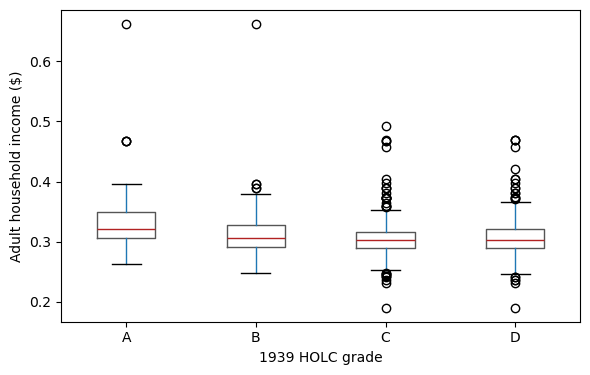

In [27]:
joined = gpd.overlay(g, holc_det[["grade","geometry"]], how="intersection")

fig, ax = plt.subplots(figsize=(6,4))
joined.boxplot(column="kfr_black_pooled_p25",
               by="grade", ax=ax, grid=False,
               boxprops=dict(color="#555"),
               medianprops=dict(color="firebrick"))
ax.set_xlabel("1939 HOLC grade")
ax.set_ylabel("Adult household income ($)")
ax.set_title(""); fig.suptitle("")
plt.tight_layout()
plt.show()


✔️  Tracts in 400-m strip: 22
✔️  oa_strip.geojson written


/var/folders/ds/gwcklq3s5hz63g6lz2gxzgnr0000gn/T/ipykernel_11080/415864309.py:63: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x_mid = row_poly.geometry.centroid.x.mean()
/var/folders/ds/gwcklq3s5hz63g6lz2gxzgnr0000gn/T/ipykernel_11080/415864309.py:64: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  wayne_oa["side"] = np.where(wayne_oa.geometry.centroid.x < x_mid,


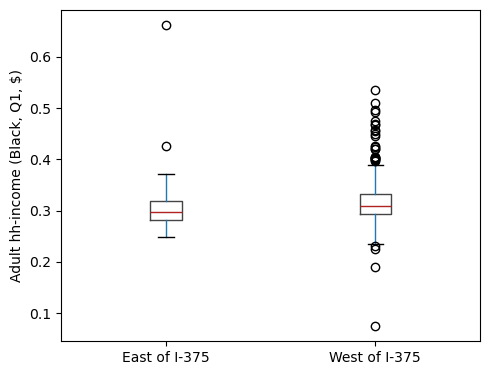

In [30]:
# ------------------------------------------------------------------
# 0 · imports + helper
# ------------------------------------------------------------------
import geopandas as gpd, pandas as pd, numpy as np, matplotlib.pyplot as plt
import folium, json, re
from branca.colormap import linear
from IPython.display import display

read = lambda fp: gpd.read_file(fp, engine="pyogrio")  # modern driver

roads_fp  = "tl_2024_26163_roads.shp"
tracts_fp = "tl_2020_26_tract.shp"
holc_fp   = "mappinginequality.json"
oa_fp     = "tract_outcomes_simple.csv"

# ------------------------------------------------------------------
# 1 · data layers
# ------------------------------------------------------------------
# 1-A  I-375 mainline + service roads
roads = read(roads_fp)
i375  = roads[
    roads["FULLNAME"].str.contains(r"\b375\b", flags=re.I, na=False) &
    roads["MTFCC"].isin(["S1100","S1400"])
]

row_poly = gpd.GeoDataFrame(
    geometry=i375.to_crs(26917).buffer(35).to_crs(4326),
    crs="EPSG:4326"
)

# 1-B  2020 tracts + Opportunity-Atlas slice (Wayne County)
tracts = read(tracts_fp)
wayne  = tracts[tracts["COUNTYFP"] == "163"].copy()

oa = (pd.read_csv(oa_fp)
        .query("state == 26 and county == 163")
        .assign(GEOID=lambda d:
            d.state.astype(str).str.zfill(2) +
            d.county.astype(str).str.zfill(3) +
            d.tract.astype(str).str.zfill(6)))
wayne_oa = wayne.merge(oa, on="GEOID").to_crs(4326)

# ------------------------------------------------------------------
# 2 · build 400-m corridor + intersection
# ------------------------------------------------------------------
corridor_geom = (
    row_poly.to_crs(26917)          # metres (UTM-17N)
            .buffer(165)            # 35 m ROW + 130 m each side
            .to_crs(4326)           # back to lat/lon
)

corridor = gpd.GeoDataFrame(geometry=corridor_geom, crs="EPSG:4326")

strip = gpd.overlay(wayne_oa, corridor, how="intersection")
print("✔️  Tracts in 400-m strip:", len(strip))

strip.to_file("oa_strip.geojson", driver="GeoJSON")  # for Folium
print("✔️  oa_strip.geojson written")

# ------------------------------------------------------------------
# 3 · east vs. west wage box-plot (side = centroid test)
# ------------------------------------------------------------------
x_mid = row_poly.geometry.centroid.x.mean()
wayne_oa["side"] = np.where(wayne_oa.geometry.centroid.x < x_mid,
                            "West of I-375", "East of I-375")

fig, ax = plt.subplots(figsize=(5,4))
wayne_oa.boxplot(column="kfr_black_pooled_p25",
                 by="side", ax=ax, grid=False,
                 boxprops=dict(color="#444"),
                 medianprops=dict(color="firebrick"))
ax.set_xlabel(""); ax.set_ylabel("Adult hh-income (Black, Q1, $)")
ax.set_title(""); fig.suptitle("")
plt.tight_layout()
plt.show()


In [31]:

# ---------------------------------------------------------------
# 1 · Layers you already have or can rebuild quickly
# ---------------------------------------------------------------
# 1-A  I-375 right-of-way (~70 m)
roads = read(roads_fp)
i375  = roads[
    roads["FULLNAME"].str.contains(r"\b375\b", flags=re.I, na=False) &
    roads["MTFCC"].isin(["S1100","S1400"])
]
row_poly = gpd.GeoDataFrame(
    geometry=i375.to_crs(26917).buffer(35).to_crs(4326),
    crs="EPSG:4326"
)

# 1-B  Detroit 1939 HOLC polygons (drop missing grades)
holc_det = (read(holc_fp)
              .query("city == 'Detroit'")
              .loc[lambda d: d.grade.notna()]
              .to_crs(4326))
grade_colors = {"A":"#4caf50","B":"#2196f3","C":"#ffeb3b","D":"#f44336"}

# 1-C  Opportunity-Atlas tracts (Wayne County)
tracts = read(tracts_fp)
wayne  = tracts[tracts["COUNTYFP"] == "163"].to_crs(4326)

oa = (pd.read_csv(oa_fp)
        .query("state == 26 and county == 163")
        .assign(GEOID=lambda d:
            d.state.astype(str).str.zfill(2) +
            d.county.astype(str).str.zfill(3) +
            d.tract.astype(str).str.zfill(6)))

wayne_oa = wayne.merge(oa, on="GEOID")

# ---------------------------------------------------------------
# 2 · Create 400 m-wide corridor + intersect
# ---------------------------------------------------------------
corridor = (row_poly.to_crs(26917).buffer(165).to_crs(4326))
corridor = gpd.GeoDataFrame(geometry=corridor, crs="EPSG:4326")

strip = gpd.overlay(wayne_oa, corridor, how="intersection")

# ---------------------------------------------------------------
# 3 · Build interactive Folium map
# ---------------------------------------------------------------
minx, miny, maxx, maxy = row_poly.total_bounds
center = [(miny+maxy)/2, (minx+maxx)/2]

m = folium.Map(location=center, zoom_start=15, tiles="cartodbpositron")

# 3-A 1960s HOLC fill layer
folium.GeoJson(
    holc_det,
    name="1939 HOLC zones",
    style_function=lambda f: {
        "color":grade_colors[f["properties"]["grade"]],
        "fillColor":grade_colors[f["properties"]["grade"]],
        "weight":1, "fillOpacity":0.15}
).add_to(m)

# 3-B I-375 ROW
folium.GeoJson(
    row_poly,
    name="I-375 ROW (~70 m)",
    style_function=lambda *_: {"color":"#e91e63","weight":2,"fillOpacity":0.25}
).add_to(m)

# 3-C OA income strip
cm = linear.YlGnBu_07.scale(
        strip.kfr_black_pooled_p25.min(skipna=True),
        strip.kfr_black_pooled_p25.max(skipna=True))

def oa_style(f):
    v = f["properties"]["kfr_black_pooled_p25"]
    col = "#999999" if pd.isna(v) else cm(v)
    return {"fillColor":col, "color":"#222","weight":0.3,"fillOpacity":0.85}

folium.GeoJson(
    json.loads(strip.to_json()),
    name="OA income (Black, Q1)",
    style_function=oa_style,
    tooltip=folium.GeoJsonTooltip(
        fields=["GEOID","kfr_black_pooled_p25"],
        aliases=["Tract","Adult hh-income ($)"],
        localize=True, digits=0)
).add_to(m)

cm.caption = ("Adult household income (2015 $) for Black children raised "
              "in bottom-income quintile – tracts ≤400 m from I-375")
cm.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

display(m)                       # shows inline in Jupyter
# m.save("i375_income_corridor.html")  # uncomment to export

In [32]:
 

# ------------------------------------------------------------------
# 1 · data layers
# ------------------------------------------------------------------
# 1-A • I-375 right-of-way (~70 m)
roads = read(roads_fp)
i375  = roads[
    roads["FULLNAME"].str.contains(r"\b375\b", na=False, case=False) &
    roads["MTFCC"].isin(["S1100","S1400"])
]
row_poly = gpd.GeoDataFrame(
    geometry=i375.to_crs(26917).buffer(35).to_crs(4326),  # 35 m half-width
    crs="EPSG:4326"
)

# 1-B • 1939 HOLC polygons (Detroit only)
holc_det = (read(holc_fp)
              .query("city == 'Detroit'")
              .loc[lambda d: d.grade.notna()]
              .to_crs(4326))
grade_colors = {"A":"#4caf50","B":"#2196f3","C":"#ffeb3b","D":"#f44336"}

# isolate D-38 for special styling
d38 = holc_det[holc_det["label"] == "D-38"]

# 1-C • Wayne-County OA tracts
tracts = read(tracts_fp)
wayne  = tracts[tracts["COUNTYFP"] == "163"].to_crs(4326)

oa = (pd.read_csv(oa_fp)
        .query("state == 26 and county == 163")
        .assign(GEOID=lambda d:
            d.state.astype(str).str.zfill(2) +
            d.county.astype(str).str.zfill(3) +
            d.tract.astype(str).str.zfill(6)))
wayne_oa = wayne.merge(oa, on="GEOID")

# ------------------------------------------------------------------
# 2 · 400 m corridor around the freeway
# ------------------------------------------------------------------
corridor = (row_poly.to_crs(26917).buffer(165).to_crs(4326))
corridor = gpd.GeoDataFrame(geometry=corridor, crs="EPSG:4326")

strip = gpd.overlay(wayne_oa, corridor, how="intersection")

# ------------------------------------------------------------------
# 3 · folium map
# ------------------------------------------------------------------
minx, miny, maxx, maxy = row_poly.total_bounds
center = [(miny + maxy)/2, (minx + maxx)/2]
m = folium.Map(location=center, zoom_start=15, tiles="cartodbpositron")

# 3-A • all HOLC zones (muted)
folium.GeoJson(
    holc_det,
    name="1939 HOLC zones",
    style_function=lambda f: {
        "color":grade_colors[f["properties"]["grade"]],
        "fillColor":grade_colors[f["properties"]["grade"]],
        "weight":1, "fillOpacity":0.15}
).add_to(m)

# 3-B • bold outline for D-38
folium.GeoJson(
    d38,
    name="D-38 outline",
    style_function=lambda *_: {
        "color":"#ff0000", "weight":4,
        "fillColor":"#ff0000", "fillOpacity":0.05}
).add_to(m)

# 3-C • I-375 ROW (full)
folium.GeoJson(
    row_poly,
    name="I-375 ROW (~70 m)",
    style_function=lambda *_: {"color":"#e91e63","weight":2,"fillOpacity":0.25}
).add_to(m)

# 3-D • I-375 *inside* D-38 (hot-pink highlight)
row_in_d38 = gpd.overlay(row_poly, d38, how="intersection")
folium.GeoJson(
    row_in_d38,
    name="I-375 inside D-38",
    style_function=lambda *_: {"color":"#ff1493","weight":4,"fillOpacity":0.4}
).add_to(m)

# 3-E • OA income strip (tracts ≤400 m)
cm = linear.YlGnBu_07.scale(
        strip.kfr_black_pooled_p25.min(skipna=True),
        strip.kfr_black_pooled_p25.max(skipna=True))

def oa_style(f):
    v = f["properties"]["kfr_black_pooled_p25"]
    col = "#999999" if pd.isna(v) else cm(v)
    return {"fillColor":col, "color":"#222","weight":0.3,"fillOpacity":0.85}

folium.GeoJson(
    json.loads(strip.to_json()),
    name="OA income (Black, Q1)",
    style_function=oa_style,
    tooltip=folium.GeoJsonTooltip(
        fields=["GEOID","kfr_black_pooled_p25"],
        aliases=["Tract","Adult hh-income ($)"],
        localize=True, digits=0)
).add_to(m)
cm.caption = ("Adult household income (2015 $) for Black children raised "
              "in bottom-income quintile – tracts ≤400 m from I-375")
cm.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

display(m)              # inline in Jupyter / VS Code
# m.save("d38_income_corridor.html")  # uncomment to export HTML


In [33]:
 
# ------------------------------------------------------------------
# 1 · pull I-375 right-of-way (~70 m)
# ------------------------------------------------------------------
roads = read(roads_fp)

i375 = roads[
    roads["FULLNAME"].str.contains(r"\b375\b", na=False, case=False) &
    roads["MTFCC"].isin(["S1100","S1400"])              # mainline + svc
]

row_poly = gpd.GeoDataFrame(
    geometry=i375.to_crs(26917).buffer(35).to_crs(4326),
    crs="EPSG:4326")

# ------------------------------------------------------------------
# 2 · get HOLC D-38 polygon
# ------------------------------------------------------------------
holc_det = read(holc_fp).query("city == 'Detroit'").to_crs(4326)
d38 = holc_det[holc_det["label"].str.strip().str.upper() == "D-38"]

# ------------------------------------------------------------------
# 3 · intersect freeway ROW with D-38
# ------------------------------------------------------------------
row_in_d38 = gpd.overlay(row_poly, d38, how="intersection")

# fall-back: if no overlap, highlight full ROW
hi_target = row_in_d38 if not row_in_d38.empty else row_poly
hi_name   = "I-375 inside D-38" if not row_in_d38.empty else "Full I-375 ROW"

# ------------------------------------------------------------------
# 4 · build Folium map
# ------------------------------------------------------------------
minx, miny, maxx, maxy = row_poly.total_bounds
center = [(miny+maxy)/2, (minx+maxx)/2]

m = folium.Map(location=center, zoom_start=15, tiles="cartodbpositron")

# base HOLC shading
grade_colors = {"A":"#4caf50","B":"#2196f3","C":"#ffeb3b","D":"#f44336"}
folium.GeoJson(
    holc_det[holc_det["grade"].notna()],
    name="1939 HOLC zones",
    style_function=lambda f: {
        "color":grade_colors[f["properties"]["grade"]],
        "fillColor":grade_colors[f["properties"]["grade"]],
        "weight":1,"fillOpacity":0.15}
).add_to(m)

# subtle full ROW
folium.GeoJson(
    row_poly,
    name="I-375 ROW (~70 m)",
    style_function=lambda *_: {"color":"#e91e63","weight":2,"fillOpacity":0.25}
).add_to(m)

# bold hot-pink highlight (overlap or full)
folium.GeoJson(
    hi_target,
    name=hi_name,
    style_function=lambda *_: {"color":"#ff1493","weight":4,"fillOpacity":0.5}
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
display(m)                       # inline in Jupyter / VS Code
# m.save("d38_highlight_map.html")   # uncomment to export HTML


In [35]:
print("How many rows in holc_det?", len(holc_det))
print("Example labels that begin with 'D-3':")
print(holc_det[holc_det["label"].str.contains(r"D-\s*3", na=False, case=False)]
      ["label"].unique()[:10])


How many rows in holc_det? 239
Example labels that begin with 'D-3':
[]


In [40]:
# ---------------------------------------------------------------
# 0 · Imports + helper
# ---------------------------------------------------------------
import geopandas as gpd, folium, json
from IPython.display import display

read = lambda fp: gpd.read_file(fp, engine="pyogrio")   # robust driver

roads_fp = "tl_2024_26163_roads.shp"   # .shp + .shx + .dbf present
holc_fp  = "mappinginequality.json"

# ---------------------------------------------------------------
# 1 · Layers
# ---------------------------------------------------------------
roads = read(roads_fp).to_crs(4326)           # ensure lat/lon
holc  = read(holc_fp).query("city == 'Detroit'").to_crs(4326)

d38   = holc[holc["label"] == "D38"]          # the “hazardous” district
if d38.empty:
    raise ValueError("Could not find D38 label — check naming.")

# • Freeways  … MTFCC == S1100
fwy   = roads[roads["MTFCC"] == "S1100"]

# • Avenues / major surface roads … MTFCC == S1200
aven  = roads[roads["MTFCC"] == "S1200"]

# • Keep only the pieces that fall inside D38
fwy_in_d38  = gpd.overlay(fwy,  d38, how="intersection")
aven_in_d38 = gpd.overlay(aven, d38, how="intersection")

# ---------------------------------------------------------------
# 2 · Build map
# ---------------------------------------------------------------
grade_colors = {"A":"#4caf50","B":"#2196f3","C":"#ffeb3b","D":"#f44336"}

minx, miny, maxx, maxy = d38.total_bounds
m = folium.Map(location=[(miny+maxy)/2, (minx+maxx)/2],
               zoom_start=15, tiles="cartodbpositron")

# 2-A  faint HOLC polygons
folium.GeoJson(
    holc[holc["grade"].notna()],
    name="1939 HOLC grades",
    style_function=lambda f: {
        "color":grade_colors[f["properties"]["grade"]],
        "fillColor":grade_colors[f["properties"]["grade"]],
        "weight":1, "fillOpacity":0.12}
).add_to(m)

# 2-B  bold outline for D38
folium.GeoJson(
    d38,
    name="D38 outline",
    style_function=lambda *_: {
        "color":"#ff0000","weight":4,
        "fillColor":"#ff0000","fillOpacity":0.06}
).add_to(m)

# 2-C  full freeway & avenue network (thin, dashed, grey) for context
road_ctx = roads[roads["MTFCC"].isin(["S1100","S1200"])]
folium.GeoJson(
    road_ctx,
    name="Freeways & avenues (context)",
    style_function=lambda *_: {
        "color":"#666666","weight":1,"dashArray":"4,4","fillOpacity":0}
).add_to(m)

# 2-D  highlight freeway segments inside D38
folium.GeoJson(
    fwy_in_d38,
    name="Freeway inside D38",
    style_function=lambda *_: {
        "color":"#ff1493","weight":6,"fillOpacity":0}
).add_to(m)

# 2-E  highlight avenue segments inside D38
folium.GeoJson(
    aven_in_d38,
    name="Avenues inside D38",
    style_function=lambda *_: {
        "color":"#ff8c00","weight":4,"fillOpacity":0}
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
display(m)                       # shows inline in Jupyter
# m.save("d38_freeway_avenue_map.html")  # uncomment to export HTML


In [51]:
import geopandas as gpd, pandas as pd, folium, json, pyogrio
from shapely.ops import unary_union, polygonize
from IPython.display import display

# ---------- helper -------------------------------------------------
def read(fp):
    return gpd.read_file(fp, engine="pyogrio")         # robust for .shp & .json

 

# ---------- 1 · load D‑38 & road network ---------------------------
holc_det = (read(holc_fp)
              .query("city == 'Detroit'")
              .to_crs(4326))

d38 = holc_det[holc_det["label"] == "D38"]
if d38.empty:
    raise ValueError("Label 'D38' not found in HOLC file!")

roads = read(roads_fp).to_crs(4326)

# --- (a) freeway mainline segments (S1100) that intersect D‑38
free = gpd.overlay(
    roads[roads["MTFCC"] == "S1100"],
    d38, how="intersection")

# --- (b) *primary* Gratiot Avenue carriageway (S1200) inside D‑38
gratiot_main = gpd.overlay(
    roads[
        (roads["FULLNAME"].str.contains(r"Gratiot Ave", case=False, na=False)) &
        (roads["MTFCC"] == "S1200")
    ],
    d38, how="intersection")

# combine divider lines
dividers = list(free["geometry"]) + list(gratiot_main["geometry"])

# ---------- 2 · polygonize interior sub‑blocks --------------------
cuts = [d38.geometry.iloc[0].boundary] + dividers
blocks = list(polygonize(unary_union(cuts)))

blocks_gdf = gpd.GeoDataFrame(geometry=blocks, crs="EPSG:4326")
blocks_gdf["block"] = range(1, len(blocks_gdf)+1)

# ---------- 3 · categorical palette ------------------------------
palette = ["#e41a1c","#377eb8","#4daf4a","#984ea3","#ff7f00"]
blocks_gdf["color"] = [palette[i % len(palette)] for i in range(len(blocks_gdf))]

# ---------- 4 · Folium preview ------------------------------------
minx, miny, maxx, maxy = d38.total_bounds
m = folium.Map(location=[(miny+maxy)/2, (minx+maxx)/2],
               zoom_start=16, tiles="cartodbpositron")

# outline of D‑38
folium.GeoJson(
    d38, style_function=lambda *_:{
        "color":"#555","weight":3,"fillOpacity":0}
).add_to(m)

# coloured interior blocks
folium.GeoJson(
    json.loads(blocks_gdf.to_json()),
    name="D‑38 blocks (Freeway + Gratiot Ave)",
    style_function=lambda f:{
        "fillColor": f["properties"]["color"],
        "color":"#222","weight":1,"fillOpacity":0.75},
    tooltip=folium.GeoJsonTooltip(
        fields=["block"], aliases=["Block #"])
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
display(m)


In [50]:
# roads is your GeoDataFrame for tl_2024_26163_roads.shp
mask = roads["FULLNAME"].str.contains("Gratiot", case=False, na=False)

print("How many segments match ‘Gratiot’? →", mask.sum())
print(roads.loc[mask, ["FULLNAME", "RTTYP", "MTFCC"]].drop_duplicates())


How many segments match ‘Gratiot’? → 3
          FULLNAME RTTYP  MTFCC
15307  Gratiot Ave     M  S1400
21432  Gratiot Ave     M  S1200
25097   Gratiot Ct     M  S1400


In [52]:
# ------------------------------------------------------------------
# 1 · load D-38 + road network
# ------------------------------------------------------------------
holc_det = gpd.read_file(holc_fp).query("city == 'Detroit'").to_crs(4326)
d38      = holc_det[holc_det["label"] == "D38"]
roads    = gpd.read_file(roads_fp).to_crs(4326)

# -- freeway mainlines (S1100) inside D-38
free = gpd.overlay(roads[roads["MTFCC"] == "S1100"], d38, how="intersection")

# -- NEW: every Gratiot-named segment, any MTFCC, inside D-38
gratiot_all = gpd.overlay(
    roads[roads["FULLNAME"].str.contains("Gratiot", case=False, na=False)],
    d38, how="intersection")

# ------------------------------------------------------------------
# 2 · polygonize blocks using (freeway + all Gratiot segments)
# ------------------------------------------------------------------
dividers = list(free.geometry) + list(gratiot_all.geometry)
cuts   = [d38.geometry.iloc[0].boundary] + dividers
blocks = list(polygonize(unary_union(cuts)))

blocks_gdf = gpd.GeoDataFrame(geometry=blocks, crs="EPSG:4326")
blocks_gdf["block"] = range(1, len(blocks_gdf)+1)

# ------------------------------------------------------------------
# 3 · (unchanged) preview map: categorical palette
# ------------------------------------------------------------------
palette = ["#e41a1c","#377eb8","#4daf4a","#984ea3","#ff7f00"]
blocks_gdf["color"] = [palette[i % len(palette)] for i in range(len(blocks_gdf))]

minx,miny,maxx,maxy = d38.total_bounds
m = folium.Map(location=[(miny+maxy)/2,(minx+maxx)/2], zoom_start=16,
               tiles="cartodbpositron")

folium.GeoJson(d38, style_function=lambda *_:{
    "color":"#555","weight":3,"fillOpacity":0}).add_to(m)

folium.GeoJson(
    json.loads(blocks_gdf.to_json()),
    name="D-38 blocks (Freeway + ALL Gratiot)",
    style_function=lambda f:{
        "fillColor": f["properties"]["color"],
        "color":"#222","weight":1,"fillOpacity":0.75},
    tooltip=folium.GeoJsonTooltip(fields=["block"], aliases=["Block #"])
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
display(m)
